In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

import re
import numpy as np

import helper_functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
_all_valid_AA_code = "RKDEQNHSTYCMWAILFVPG"
_invalid_AA_regex = "[^%s]" % _all_valid_AA_code #negacija svih validnih

assert( len(_all_valid_AA_code) == 20 )

def AA_is_valid(seq, invalid_regex=None):
    ''' Return True if no invalid AA code can be found ''' 
    return not re.search(invalid_regex or _invalid_AA_regex, seq)

def AA_show_invalid(seq, invalid_regex=None):
    ''' Return Counter object showing all iregularites '''
    return Counter(re.findall(invallid_regex or _invalid_AA_regex, seq))



###  Ucitavamo proteine

In [3]:
all_proteins = [r for r in SeqIO.parse("data/CAFA3_training_data/uniprot_sprot_exp.fasta", "fasta")]
print("ukupno originalnih proteina:", len(all_proteins))

ukupno originalnih proteina: 66841


In [4]:
all_valid_proteins = [r for r in all_proteins 
                            if AA_is_valid(str(r.seq)) and len(r.seq)>=9] #minimum 9 jer vsl2b ne podrzva manje

print("ukupno validnih proteina:", len(all_valid_proteins))
print("validnih > 40AK:", sum( len(r.seq)>40 for r in all_valid_proteins ) )

ukupno validnih proteina: 66599
validnih > 40AK: 66063


###  Cuvamo validne proteine u valid_proteins.fasta

### Random i Uniform modele 

In [5]:
def AAfequency(records):
    """generate a dict that represents a free variable for AA code
       based on AA sequence in fasta file 
    """
    from collections import Counter
    c = Counter()
    N = 0 # ukupna duzina svih proteina
    for record in records:
        c.update(record.seq)
        N += len(record.seq) 

    return { ak: k/N   for ak, k in c.items()}

AAfreq = AAfequency(all_valid_proteins)

### Crtamo AK ucestalosti

In [6]:
ak_info = pd.read_csv('data/ak_info', sep=' ', escapechar='\\' )
ak_info.head()

,id,id3,name,avg,exact,duno
0,G,Gly,Glycine,75.07,75.03,57
1,A,Ala,Alanine,89.10,89.05,71
2,S,Ser,Serine,105.09,105.04,87
3,P,Pro,Proline,115.13,115.05,97
4,V,Val,Valine,117.15,117.08,99


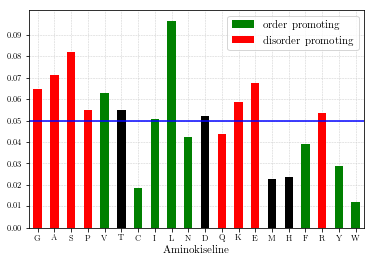

In [7]:
import pandas as pd

order_promoting = {ak for ak in "CWYFILVN"}
disorder_promoting = {ak for ak in "PRGQSEKA"}

ak_values = []

for ak in ak_info.id:
    p = AAfreq[ak]
    v = [ak, p, 0, 0]
    if ak in order_promoting:
        v[2] = p
    elif ak in disorder_promoting:
        v[3] = p
    ak_values.append(v)
    
df = pd.DataFrame( ak_values, columns=("AK", "p", 'po', 'pd')).set_index("AK")
ax = df.p.plot(kind = 'bar', rot=True, yticks=np.arange(0,0.1, 0.01), color='k')
df.po.plot(kind = 'bar', rot=True, yticks=np.arange(0,0.1, 0.01), sharey=True, color='g' )
df.pd.plot(kind = 'bar', rot=True, yticks=np.arange(0,0.1, 0.01), sharey=True, color='r' )

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

green_patch = mpatches.Patch(facecolor='g', label='order promoting',)
red_patch = mpatches.Patch(facecolor='r', label='disorder promoting',)

plt.legend(handles=[green_patch, red_patch])

ax.set_xlabel("Aminokiseline")
ax.set_axisbelow(True)
ax.plot((-1,20), (1/20, 1/20), c='b' ) 
plt.savefig("plots/AK_ucestalost.pdf")

#  generisemo random i uniformne varijante i cuvamo u fajl

Ovo radimo samo jedanput na pocetku

In [8]:
def makeRandomRecord(org_record, model):
    return SeqRecord( Seq( model(len(org_record.seq)), IUPAC.protein)
                      , id=org_record.id, name=org_record.name, description="" )